<a href="https://colab.research.google.com/github/wko1014/GAN_Study/blob/main/notes/infoGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import APIs
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Download MNIST Dataset
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./MNIST_data/data/", one_hot=True)

# Define Hyperparameters and Placehoders
epochs = 100
batch_size = 32
learning_rate = 1e-3
n_noise = 16
n_code = 10
n_image = 28 * 28 # The size of MNIST

X = tf.placeholder(tf.float32, [None, n_image])
Z = tf.placeholder(tf.float32, [None, n_noise])
c1 = tf.placeholder(tf.float32, [None, n_code])

Extracting ./MNIST_data/data/train-images-idx3-ubyte.gz
Extracting ./MNIST_data/data/train-labels-idx1-ubyte.gz
Extracting ./MNIST_data/data/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data/data/t10k-labels-idx1-ubyte.gz


In [ ]:
# Define Modules
def get_params(name, shape):
  weight = tf.get_variable(name=name+"w", shape=shape, initializer=tf.random_normal_initializer(stddev=0.01))
  filtercnt = shape[-1]
  bias = tf.get_variable(name=name+"b", shape=[filtercnt], initializer=tf.zeros_initializer)
  return weight, bias

In [ ]:
# Define Generator (George)
def generator(noise, code):
    with tf.variable_scope("george"):
        inputs = tf.concat((noise, code), axis=1)

        G_w1, G_b1 = get_params(name="g_layer1", shape=[n_noise + n_code, 256])
        layer1 = tf.nn.relu(tf.matmul(inputs, G_w1) + G_b1)

        G_wo, G_bo = get_params(name="g_output_layer", shape=[256, n_image])
        output = tf.nn.sigmoid(tf.matmul(layer1, G_wo) + G_bo)
    return output

In [ ]:
# Define Discriminator (Danielle)
def discriminator(image, reuse=False):
    with tf.variable_scope("danielle", reuse=reuse):
        D_w1, D_b1 = get_params(name="d_layer1", shape=[n_image, 128])
        layer1 = tf.nn.relu(tf.matmul(image, D_w1) + D_b1)

        D_wo, D_bo = get_params(name="d_output_layer", shape=[128, 1])
        output = tf.nn.sigmoid(tf.matmul(layer1, D_wo) + D_bo)
    return output

In [ ]:
# Define Auxiliary distribution Q
def Q(inputs):
    with tf.variable_scope("aux_distribution"):
        Q_w1, Q_b1 = get_params(name="q_layer1", shape=[n_image, 128])
        layer1 = tf.nn.relu(tf.matmul(inputs, Q_w1) + Q_b1)

        Q_wo, Q_bo = get_params(name="q_output_layer", shape=[128, n_code])
        output = tf.nn.sigmoid(tf.matmul(layer1, Q_wo) + Q_bo)
    return output

In [ ]:
# Sample Random Noise Vector
def get_noise(batch_size, n_noise):
  return np.random.normal(size=(batch_size, n_noise))

def get_code(batch_size):
    return np.random.multinomial(1, 10*[0.1], size=batch_size)

In [ ]:
# George Generates Counterfeits
G_sample = generator(noise=Z, code=c1)

# Danielle Discriminates Real Bills and Counterfeits
D_real = discriminator(X)
D_fake = discriminator(G_sample, reuse=True)
Q_c_given_x = Q(G_sample)

# GANs Objective Function
loss_D = tf.reduce_mean(tf.log(D_real) + tf.log(1 - D_fake))
loss_G = tf.reduce_mean(tf.log(D_fake))
loss_Q = tf.reduce_mean(-tf.reduce_sum(tf.log(Q_c_given_x) * c1, 1))

Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
# Collect George's and Danielle's Variables
D_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="danielle")
G_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="george")
Q_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="aux_distribution")

# Optimization using Adam Optimizer
train_D = tf.train.AdamOptimizer(learning_rate).minimize(-loss_D, var_list=D_var_list)
train_G = tf.train.AdamOptimizer(learning_rate).minimize(-loss_G, var_list=G_var_list)
train_Q = tf.train.AdamOptimizer(learning_rate).minimize(loss_Q, var_list=G_var_list + Q_var_list)

Instructions for updating:
Use tf.cast instead.


In [ ]:
# Nerual Networks Training
sess = tf.Session()
sess.run(tf.global_variables_initializer())

total_batch = int(mnist.train.num_examples / batch_size)
loss_var_D, loss_var_G = 0, 0

for epoch in range(epochs):
    for batch in range(total_batch):
        batch_x, _ = mnist.train.next_batch(batch_size)
        noise = get_noise(batch_size, n_noise)
        code = get_code(batch_size)

        _, loss_val_D = sess.run([train_D, loss_D], feed_dict={X: batch_x, Z: noise, c1: code})
        _, loss_val_G = sess.run([train_G, loss_G], feed_dict={Z: noise, c1: code})
        sess.run([train_Q], feed_dict={Z: noise, c1: code})

    print("Epoch:", "%04d" % epoch, "D loss: {:.4}".format(loss_val_D), "G loss: {:.4}".format(loss_val_G))


    if epoch == 0 or (epoch + 1) % 10 == 0:
        sample_size = 10
        noise = get_noise(sample_size, n_noise)
        code1 = get_code(sample_size)

        generated_samples = sess.run(G_sample, feed_dict={Z: noise, c1: np.eye(sample_size)})

        fig, ax = plt.subplots(1, sample_size, figsize=(sample_size, 1))

        for i in range(sample_size):
            ax[i].set_axis_off()
            ax[i].imshow(np.reshape(generated_samples[i], (28, 28)))

        plt.savefig("./{}.png".format(str(epoch).zfill(3)), bbox_inches="tight")
        plt.close(fig)

print("Optimization Complete!")

Epoch: 0000 D loss: -0.1398 G loss: -3.433
Epoch: 0001 D loss: -0.551 G loss: -2.6
Epoch: 0002 D loss: -1.032 G loss: -1.715
Epoch: 0003 D loss: -0.9252 G loss: -1.819
Epoch: 0004 D loss: -1.623 G loss: -1.349
Epoch: 0005 D loss: -1.485 G loss: -0.9913
Epoch: 0006 D loss: -1.205 G loss: -1.15
Epoch: 0007 D loss: -1.246 G loss: -1.038
Epoch: 0008 D loss: -1.49 G loss: -0.8649
Epoch: 0009 D loss: -1.157 G loss: -1.203
Epoch: 0010 D loss: -0.9454 G loss: -1.26
Epoch: 0011 D loss: -1.313 G loss: -0.8708
Epoch: 0012 D loss: -1.135 G loss: -0.9294
Epoch: 0013 D loss: -0.9649 G loss: -1.302
Epoch: 0014 D loss: -1.086 G loss: -0.9939
Epoch: 0015 D loss: -1.591 G loss: -0.8045
Epoch: 0016 D loss: -1.204 G loss: -1.025
Epoch: 0017 D loss: -1.197 G loss: -0.8838
Epoch: 0018 D loss: -1.341 G loss: -0.8938
Epoch: 0019 D loss: -1.319 G loss: -0.8213
Epoch: 0020 D loss: -1.196 G loss: -0.8646
Epoch: 0021 D loss: -1.282 G loss: -0.8858
Epoch: 0022 D loss: -1.462 G loss: -0.9502
Epoch: 0023 D loss: -1.

KeyboardInterrupt: ignored

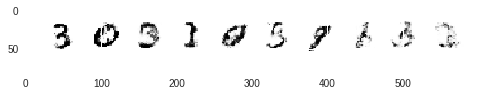

In [ ]:
import matplotlib.image as mpimg

img = mpimg.imread("./069.png")
plt.imshow(img)
plt.show()